### Importy

In [29]:
import pandas as pd
import numpy as np
import os
import joblib
from math import radians, sin, cos, sqrt, atan2

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBRegressor


### Ścieżki

In [30]:
# === Ścieżki
DATA_PATH = "../data/final_data.csv"
MODEL_PATH = "final_models/price_classifier.pkl"
KMEANS_PATH = "final_models/kmeans_location_cluster.pkl"
ATTRIBUTES_PATH = "utils/attributes.txt"

### Funkcje pomocnicze

In [31]:
# === Pomocnicza klasa
class PassthroughTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X): return X

### Wczytanie danych

In [32]:
df = pd.read_csv("../data/final_data.csv", delimiter=';')
df.drop(columns=["id"], inplace=True)

### Dodatkowa analiza rozkładów i outlierów
Cel: Zidentyfikować i zrozumieć, które obserwacje ekstremalne (ceny > pewien próg) wypaczają odchylenie standardowe i R².

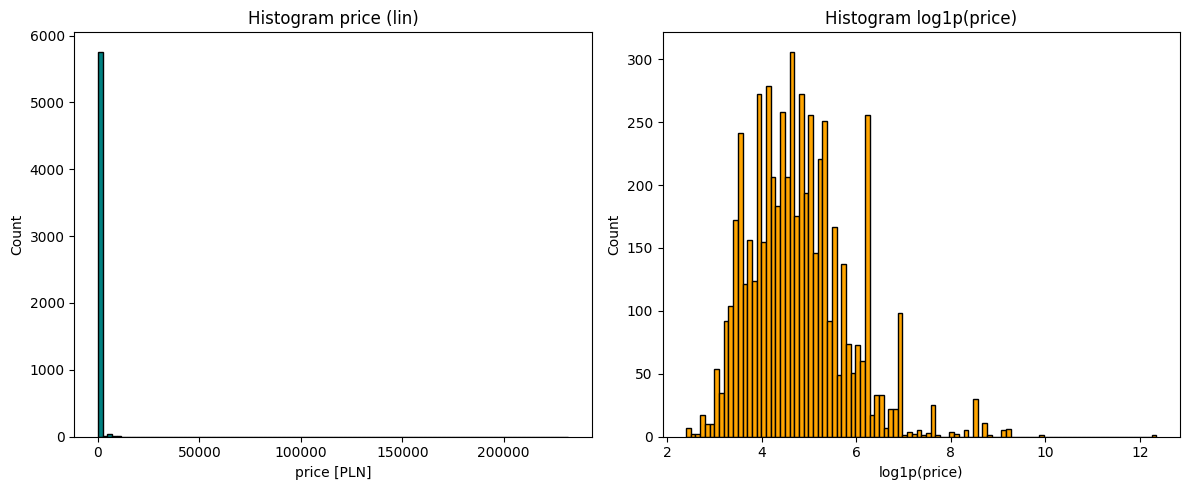

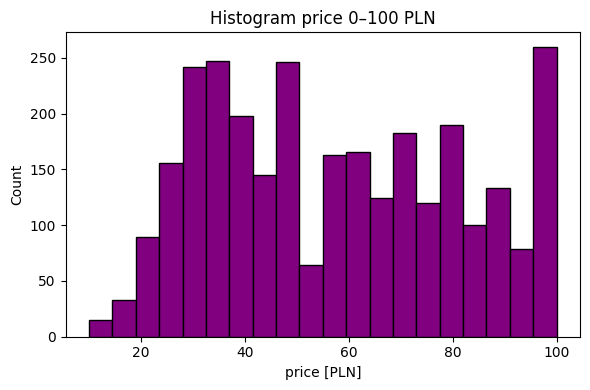

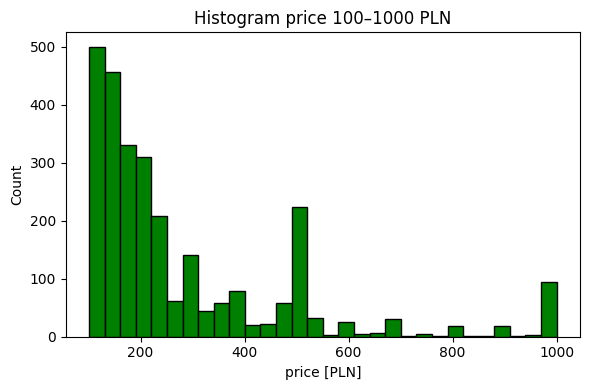

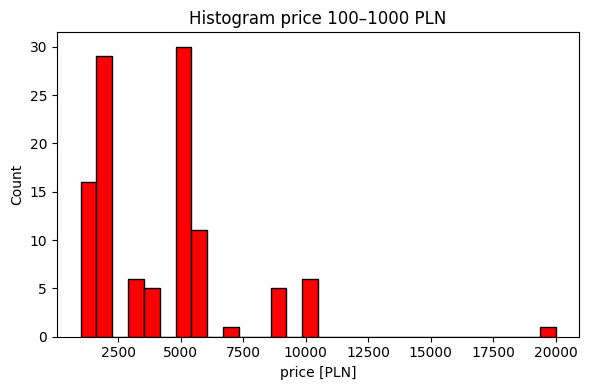

Price > 10 PLN: 99.95% obserwacji
Price > 25 PLN: 96.07% obserwacji
Price > 50 PLN: 76.47% obserwacji
Price > 100 PLN: 49.31% obserwacji
Price > 200 PLN: 23.62% obserwacji
Price > 300 PLN: 15.19% obserwacji
Price > 400 PLN: 11.72% obserwacji
Price > 500 PLN: 7.64% obserwacji
Price > 1000 PLN: 1.91% obserwacji
Price > 2000 PLN: 1.15% obserwacji
Price > 5000 PLN: 0.43% obserwacji


In [33]:
#Histogram cen w skali liniowej i logarytmicznej
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=100, color='teal', edgecolor='black')
plt.title('Histogram price (lin)')
plt.xlabel('price [PLN]')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df['price']), bins=100, color='orange', edgecolor='black')
plt.title('Histogram log1p(price)')
plt.xlabel('log1p(price)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Histogram tylko dla cen 0–100 PLN
plt.figure(figsize=(6, 4))
subset_0_100 = df[df['price'] <= 100]
plt.hist(subset_0_100['price'], bins=20, color='purple', edgecolor='black')
plt.title('Histogram price 0–100 PLN')
plt.xlabel('price [PLN]')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Histogram tylko dla cen 100–1000 PLN
plt.figure(figsize=(6, 4))
subset_100_1000 = df[(df['price'] > 100) & (df['price'] <= 1000)]
plt.hist(subset_100_1000['price'], bins=30, color='green', edgecolor='black')
plt.title('Histogram price 100–1000 PLN')
plt.xlabel('price [PLN]')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Histogram tylko dla cen 1000+ PLN
plt.figure(figsize=(6, 4))
subset_100_1000 = df[(df['price'] > 1000)& (df['price'] <= 100000)]
plt.hist(subset_100_1000['price'], bins=30, color='red', edgecolor='black')
plt.title('Histogram price 100–1000 PLN')
plt.xlabel('price [PLN]')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Proporcja ofert powyżej różnych progów
for threshold in [10, 25, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000]:
    pct = (df['price'] > threshold).mean() * 100
    print(f"Price > {threshold} PLN: {pct:.2f}% obserwacji")

Widać, że ilość ofert dla danej ceny nie jest rozłożona równomiernie. Na podstawie wcześniejszych (mało udanych) prób proponujemy rozpatrywać różne przedziały cenowe osobno. 
Jako przedziały zostały wybrane:
- 0-100 PLN
- 100-300 PLN
- 300-1000 PLN
- 1000+ PLN 

Należy stworzyć klasyfikator, który przypisze mieszkanie do potencjalnego przedziału cenowego oraz zestaw czterech regresorów dla każdgeo z nich.

### Feature engineering
W celu poprawy działania modeli proponujemy dodać potencjalnie przydatne cechy:

In [34]:
# === Funkcja odległości do centrum Barcelony
def haversine(lat1, lon1, lat2=41.3870, lon2=2.1701):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# === Wczytanie danych
df = pd.read_csv(DATA_PATH, sep=";")
df = df[(df["price"] >= df["price"].quantile(0.01)) & (df["price"] <= df["price"].quantile(0.99))].copy()

# === Feature engineering
df["bathrooms_per_guest"] = df["bathrooms_num"] / df["accommodates"].replace(0, np.nan)
df["bedrooms_per_guest"] = df["bedrooms"] / df["accommodates"].replace(0, np.nan)
df["beds_per_guest"] = df["beds"] / df["accommodates"].replace(0, np.nan)
df["beds_per_bedroom"] = df["beds"] / df["bedrooms"].replace(0, np.nan)
df["guests_per_bedroom"] = df["accommodates"] / df["bedrooms"].replace(0, np.nan)
df["dist_to_center"] = df.apply(lambda row: haversine(row["latitude"], row["longitude"]), axis=1)

# === Klasteryzacja lokalizacji
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=42, n_init='auto')
df["location_cluster"] = kmeans.fit_predict(df[["latitude", "longitude"]])
joblib.dump(kmeans, KMEANS_PATH)

# === Dodatkowe cechy
amenity_cols = [col for col in df.columns if col.startswith("amenity_")]
df["num_amenities"] = df[amenity_cols].sum(axis=1)
df["has_tv_or_wifi"] = df[["amenity_TV", "amenity_Wifi"]].max(axis=1)
df["is_suited_for_longterm"] = df[["amenity_Washer", "amenity_Kitchen", "amenity_Dishes and silverware"]].sum(axis=1) >= 2
df["lat_scaled"] = (df["latitude"] - df["latitude"].mean()) / df["latitude"].std()
df["lon_scaled"] = (df["longitude"] - df["longitude"].mean()) / df["longitude"].std()
df["is_group_friendly"] = (df["accommodates"] >= 4).astype(int)

## Klasyfikator

Poniżej przedstawiono pełen kod klasyfikatora:

In [35]:
import pandas as pd
import numpy as np
import os
import joblib
from math import radians, sin, cos, sqrt, atan2

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# === Ścieżki
DATA_PATH = "../data/final_data.csv"
MODEL_PATH = "final_models/price_classifier.pkl"
KMEANS_PATH = "final_models/kmeans_location_cluster.pkl"
ATTRIBUTES_PATH = "utils/attributes.txt"

os.makedirs("final_models", exist_ok=True)

# === Pomocnicza klasa
class PassthroughTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X): return X

# === Funkcja odległości do centrum Barcelony
def haversine(lat1, lon1, lat2=41.3870, lon2=2.1701):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# === Wczytanie danych
df = pd.read_csv(DATA_PATH, sep=";")
df = df[(df["price"] >= df["price"].quantile(0.01)) & (df["price"] <= df["price"].quantile(0.99))].copy()

# === Feature engineering
df["bathrooms_per_guest"] = df["bathrooms_num"] / df["accommodates"].replace(0, np.nan)
df["bedrooms_per_guest"] = df["bedrooms"] / df["accommodates"].replace(0, np.nan)
df["beds_per_guest"] = df["beds"] / df["accommodates"].replace(0, np.nan)
df["beds_per_bedroom"] = df["beds"] / df["bedrooms"].replace(0, np.nan)
df["guests_per_bedroom"] = df["accommodates"] / df["bedrooms"].replace(0, np.nan)
df["dist_to_center"] = df.apply(lambda row: haversine(row["latitude"], row["longitude"]), axis=1)

# === Klasteryzacja lokalizacji
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=42, n_init='auto')

df["location_cluster"] = kmeans.fit_predict(df[["latitude", "longitude"]])
joblib.dump(kmeans, KMEANS_PATH)

# === Dodatkowe cechy
amenity_cols = [col for col in df.columns if col.startswith("amenity_")]
df["num_amenities"] = df[amenity_cols].sum(axis=1)
df["has_tv_or_wifi"] = df[["amenity_TV", "amenity_Wifi"]].max(axis=1)
df["is_suited_for_longterm"] = df[["amenity_Washer", "amenity_Kitchen", "amenity_Dishes and silverware"]].sum(axis=1) >= 2
df["lat_scaled"] = (df["latitude"] - df["latitude"].mean()) / df["latitude"].std()
df["lon_scaled"] = (df["longitude"] - df["longitude"].mean()) / df["longitude"].std()
df["is_group_friendly"] = (df["accommodates"] >= 4).astype(int)

# === Czyszczenie cech
for col in ["bathrooms_per_guest", "bedrooms_per_guest", "beds_per_guest", "beds_per_bedroom", "guests_per_bedroom"]:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    q_low, q_high = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(q_low, q_high).fillna(df[col].median())

# === Binning cen
bins = [0, 100, 300, 1000, np.inf]
labels = ["bin_0_100", "bin_100_300", "bin_300_1000", "bin_1000_up"]
df["price_bin"] = pd.cut(df["price"], bins=bins, labels=labels)

# === X, y
X = df.drop(columns=["price", "id", "price_bin"])
y = df["price_bin"]

# === Zapis listy wymaganych cech
with open(ATTRIBUTES_PATH, "w") as f:
    for col in X.columns:
        f.write(f"{col}\n")

# === Podział na train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Oversampling tylko na train
print("Rozkład klas przed SMOTE:")
print(y_train.value_counts(normalize=True))

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Rozkład klas po SMOTE:")
print(pd.Series(y_train_res).value_counts(normalize=True))

# === Pipeline
binary_cols = [col for col in X.select_dtypes(include="number").columns if X[col].nunique() <= 2]
numeric_cols = [col for col in X.select_dtypes(include="number").columns if col not in binary_cols]

numeric_pipeline = Pipeline([
    ("selector", PassthroughTransformer()),
    ("scaler", StandardScaler())
])
binary_pipeline = Pipeline([
    ("selector", PassthroughTransformer())
])
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("bin", binary_pipeline, binary_cols)
])

classifier_pipeline = Pipeline([
    ("pre", preprocessor),
    ("clf", HistGradientBoostingClassifier(random_state=42, class_weight="balanced"))
])

# === Trening
classifier_pipeline.fit(X_train_res, y_train_res)

# === Ewaluacja
y_pred = classifier_pipeline.predict(X_test)
print("=== Classification Report (test set) ===")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# === Macierz pomyłek
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig("final_models/confusion_matrix.png")
plt.close()

# === Zapis modelu
joblib.dump(classifier_pipeline, MODEL_PATH)
print(f"Zapisano model klasyfikatora do {MODEL_PATH}")


Rozkład klas przed SMOTE:
price_bin
bin_0_100       0.506891
bin_100_300     0.347845
bin_300_1000    0.135419
bin_1000_up     0.009845
Name: proportion, dtype: float64
Rozkład klas po SMOTE:
price_bin
bin_0_100       0.25
bin_100_300     0.25
bin_300_1000    0.25
bin_1000_up     0.25
Name: proportion, dtype: float64
=== Classification Report (test set) ===
              precision    recall  f1-score   support

   bin_0_100       0.84      0.81      0.83       579
 bin_1000_up       0.50      0.09      0.15        11
 bin_100_300       0.66      0.78      0.72       398
bin_300_1000       0.70      0.53      0.60       155

    accuracy                           0.75      1143
   macro avg       0.68      0.55      0.57      1143
weighted avg       0.76      0.75      0.75      1143

Accuracy: 0.7542
Zapisano model klasyfikatora do final_models/price_classifier.pkl


### Ewaluacja działania klasyfikatora
Poniżej kod, służący do ewaluacji działania klasyfiaktora:

In [36]:
import pandas as pd
import numpy as np
import joblib
from sklearn.base import BaseEstimator, TransformerMixin

# === Ścieżki
DATA_PATH = "../data/final_data.csv"
MODEL_PATH = "final_models/price_classifier.pkl"
OUTPUT_PATH = "bin_predictions.csv"

# === PassthroughTransformer (konieczny do odczytu modelu)
class PassthroughTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X): return X

# === Wczytaj dane
df = pd.read_csv(DATA_PATH, sep=";")
df = df[(df["price"] >= df["price"].quantile(0.01)) & (df["price"] <= df["price"].quantile(0.99))].copy()

# === Feature engineering
df["bathrooms_per_guest"] = df["bathrooms_num"] / df["accommodates"].replace(0, np.nan)
df["bedrooms_per_guest"] = df["bedrooms"] / df["accommodates"].replace(0, np.nan)
df["beds_per_guest"] = df["beds"] / df["accommodates"].replace(0, np.nan)
df["beds_per_bedroom"] = df["beds"] / df["bedrooms"].replace(0, np.nan)
df["guests_per_bedroom"] = df["accommodates"] / df["bedrooms"].replace(0, np.nan)
df["dist_to_center"] = np.nan  # można zastąpić dokładną wartością jeśli masz

# Lokalizacja
try:
    kmeans = joblib.load("final_models/kmeans_location_cluster.pkl")
    df["location_cluster"] = kmeans.predict(df[["latitude", "longitude"]])
except FileNotFoundError:
    df["location_cluster"] = 0

# Dodatkowe cechy
amenity_cols = [col for col in df.columns if col.startswith("amenity_")]
df["num_amenities"] = df[amenity_cols].sum(axis=1)
df["has_tv_or_wifi"] = df[["amenity_TV", "amenity_Wifi"]].max(axis=1)
df["is_suited_for_longterm"] = df[["amenity_Washer", "amenity_Kitchen", "amenity_Dishes and silverware"]].sum(axis=1) >= 2
df["lat_scaled"] = (df["latitude"] - df["latitude"].mean()) / df["latitude"].std()
df["lon_scaled"] = (df["longitude"] - df["longitude"].mean()) / df["longitude"].std()
df["is_group_friendly"] = (df["accommodates"] >= 4).astype(int)

for col in ["bathrooms_per_guest", "bedrooms_per_guest", "beds_per_guest", "beds_per_bedroom", "guests_per_bedroom"]:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    q_low, q_high = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(q_low, q_high).fillna(df[col].median())

# === Binning prawdziwej ceny
bins = [0, 100, 300, 1000, np.inf]
labels = ["bin_0_100", "bin_100_300", "bin_300_1000", "bin_1000_up"]
df["true_bin"] = pd.cut(df["price"], bins=bins, labels=labels)

# === Przygotowanie danych
X = df.drop(columns=["price", "id", "true_bin"])
if "price_bin" in X.columns:
    X = X.drop(columns=["price_bin"])

# === Wczytaj model
model = joblib.load(MODEL_PATH)

# === Predykcja
predicted_bins = model.predict(X)

# === Porównanie
output_df = df[["id", "price", "true_bin"]].copy()
output_df["predicted_bin"] = predicted_bins
output_df["correct"] = output_df["true_bin"] == output_df["predicted_bin"]

# === Eksport
output_df.to_csv(OUTPUT_PATH, index=False)
print(f"Zapisano wyniki do {OUTPUT_PATH}")


Zapisano wyniki do bin_predictions.csv


Wyniki są następujące:

            id  price      true_bin predicted_bin  correct
0     16989407  150.0   bin_100_300     bin_0_100    False
1     34133454  999.0  bin_300_1000  bin_300_1000     True
2  1,04185E+18  200.0   bin_100_300   bin_100_300     True
3  6,95612E+17   90.0     bin_0_100     bin_0_100     True
4       847195   90.0     bin_0_100   bin_100_300    False

Udział dobrze i źle przewidzianych przedziałów:
correct
True     0.915821
False    0.084179
Name: proportion, dtype: float64

Skuteczność klasyfikatora: 91.58%


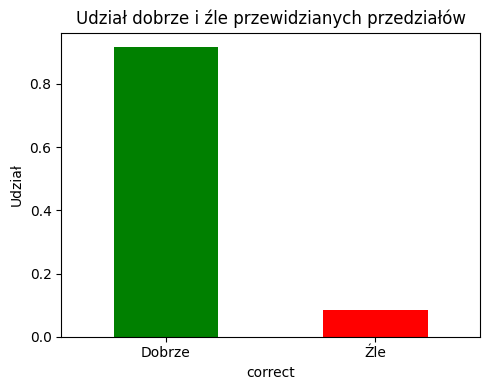

In [37]:
# Wczytaj plik z predykcjami
results = pd.read_csv("bin_predictions.csv")

# Pokaż pierwsze wiersze
print(results.head())

# Policz udział dobrze i źle przewidzianych
correct_counts = results['correct'].value_counts(normalize=True)
print("\nUdział dobrze i źle przewidzianych przedziałów:")
print(correct_counts)

# Skuteczność w procentach
accuracy_pct = 100 * correct_counts.get(True, 0)
print(f"\nSkuteczność klasyfikatora: {accuracy_pct:.2f}%")

# Wykres
plt.figure(figsize=(5, 4))
correct_counts.plot(kind='bar', color=['green', 'red'])
plt.xticks([0, 1], ['Dobrze', 'Źle'], rotation=0)
plt.ylabel('Udział')
plt.title('Udział dobrze i źle przewidzianych przedziałów')
plt.tight_layout()
plt.show()

Jak widać wyżej, klasyfikator działa dobrze w prawie 92% przypadków.

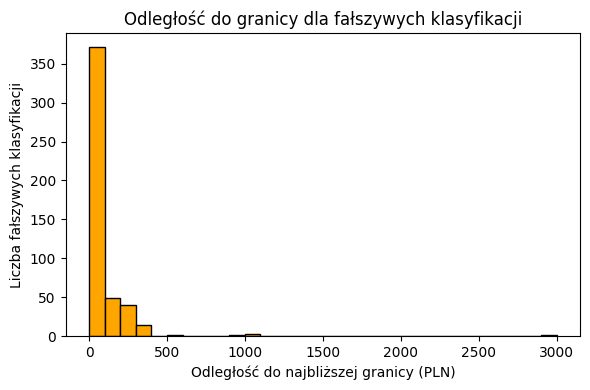

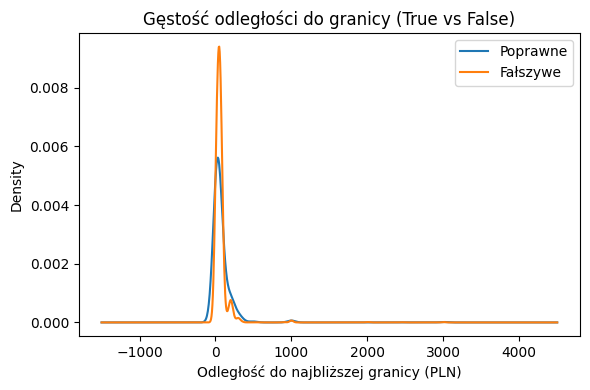

Średnia odległość do granicy (poprawne): 67.71
Średnia odległość do granicy (fałszywe): 77.56
Test Mann-Whitney U, p-value: 0.0000


In [38]:
# Sprawdź jak blisko wartości granicznych (100, 300, 1000) są ceny dla fałszywych klasyfikacji
boundaries = [100, 300, 1000]

# Dodaj kolumnę z minimalną odległością do granicy
def min_dist_to_boundary(price):
    return min(abs(price - b) for b in boundaries)

false_cases = output_df[~output_df['correct']].copy()
false_cases['dist_to_boundary'] = false_cases['price'].apply(min_dist_to_boundary)

# Histogram odległości do granicy dla fałszywych klasyfikacji
plt.figure(figsize=(6, 4))
plt.hist(false_cases['dist_to_boundary'], bins=30, color='orange', edgecolor='black')
plt.xlabel('Odległość do najbliższej granicy (PLN)')
plt.ylabel('Liczba fałszywych klasyfikacji')
plt.title('Odległość do granicy dla fałszywych klasyfikacji')
plt.tight_layout()
plt.show()

# Porównanie: odległość do granicy dla przypadków poprawnych vs fałszywych
output_df['dist_to_boundary'] = output_df['price'].apply(min_dist_to_boundary)
plt.figure(figsize=(6, 4))
output_df.groupby('correct')['dist_to_boundary'].plot(kind='kde', legend=True)
plt.xlabel('Odległość do najbliższej granicy (PLN)')
plt.title('Gęstość odległości do granicy (True vs False)')
plt.legend(['Poprawne', 'Fałszywe'])
plt.tight_layout()
plt.show()

# Test statystyczny: czy fałszywe klasyfikacje są bliżej granic niż poprawne?
from scipy.stats import mannwhitneyu
stat, pval = mannwhitneyu(
    output_df[output_df['correct']]['dist_to_boundary'],
    output_df[~output_df['correct']]['dist_to_boundary'],
    alternative='greater'
)
print(f"Średnia odległość do granicy (poprawne): {output_df[output_df['correct']]['dist_to_boundary'].mean():.2f}")
print(f"Średnia odległość do granicy (fałszywe): {output_df[~output_df['correct']]['dist_to_boundary'].mean():.2f}")
print(f"Test Mann-Whitney U, p-value: {pval:.4f}")

Widać, że spora część błędnych wykryć jest skutkiem cen leżących na granicach

## Regresory
Dla każdego z ww. przedziałów wytrenowano osobny regresor

### Regresor - przedział 0-100
Poniżej kod:

In [39]:
# Re-imports due to state reset
import pandas as pd
import numpy as np
import os
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBRegressor
from math import radians, sin, cos, sqrt, atan2
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="This Pipeline instance is not fitted yet.*",
    module="sklearn.pipeline"
)



# Ścieżki
DATA_PATH = "../data/final_data.csv"
ATTRIBUTES_PATH = "utils/attributes.txt"
MODEL_OUTPUT_PATH = "final_models/xgb_regressor_bin_0_100.pkl"
os.makedirs("final_models", exist_ok=True)

# Klasa passtrough
class PassthroughTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X): return X

# Wczytanie danych
df = pd.read_csv(DATA_PATH, sep=";")
df = df[(df["price"] >= df["price"].quantile(0.01)) & (df["price"] <= df["price"].quantile(0.99))].copy()

# Binning
bins = [0, 100, 300, 1000, np.inf]
labels = ["bin_0_100", "bin_100_300", "bin_300_1000", "bin_1000_up"]
df["price_bin"] = pd.cut(df["price"], bins=bins, labels=labels)

# Filtrowanie tylko bin_0_100
df = df[df["price_bin"] == "bin_0_100"].copy()

# Log-transformacja
df["target"] = np.log1p(df["price"])

# Feature engineering
def haversine(lat1, lon1, lat2=41.3870, lon2=2.1701):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

df["bathrooms_per_guest"] = df["bathrooms_num"] / df["accommodates"].replace(0, np.nan)
df["bedrooms_per_guest"] = df["bedrooms"] / df["accommodates"].replace(0, np.nan)
df["beds_per_guest"] = df["beds"] / df["accommodates"].replace(0, np.nan)
df["beds_per_bedroom"] = df["beds"] / df["bedrooms"].replace(0, np.nan)
df["guests_per_bedroom"] = df["accommodates"] / df["bedrooms"].replace(0, np.nan)
df["dist_to_center"] = df.apply(lambda row: haversine(row["latitude"], row["longitude"]), axis=1)

kmeans = KMeans(n_clusters=15, random_state=42, n_init='auto')

df["location_cluster"] = kmeans.fit_predict(df[["latitude", "longitude"]])

amenity_cols = [col for col in df.columns if col.startswith("amenity_")]
df["num_amenities"] = df[amenity_cols].sum(axis=1)
df["has_tv_or_wifi"] = df[["amenity_TV", "amenity_Wifi"]].max(axis=1)
df["is_suited_for_longterm"] = df[["amenity_Washer", "amenity_Kitchen", "amenity_Dishes and silverware"]].sum(axis=1) >= 2
df["lat_scaled"] = (df["latitude"] - df["latitude"].mean()) / df["latitude"].std()
df["lon_scaled"] = (df["longitude"] - df["longitude"].mean()) / df["longitude"].std()
df["is_group_friendly"] = (df["accommodates"] >= 4).astype(int)

for col in ["bathrooms_per_guest", "bedrooms_per_guest", "beds_per_guest", "beds_per_bedroom", "guests_per_bedroom"]:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    q_low, q_high = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(q_low, q_high).fillna(df[col].median())

# Wczytanie cech
with open(ATTRIBUTES_PATH) as f:
    feature_cols = [line.strip() for line in f]

X = df[feature_cols]
y = df["target"]

# Podział na zbiory
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Przetwarzanie kolumn
binary_cols = [col for col in X.select_dtypes(include="number").columns if X[col].nunique() <= 2]
numeric_cols = [col for col in X.select_dtypes(include="number").columns if col not in binary_cols]

numeric_pipeline = Pipeline([("selector", PassthroughTransformer()), ("scaler", StandardScaler())])
binary_pipeline = Pipeline([("selector", PassthroughTransformer())])
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("bin", binary_pipeline, binary_cols)
])

# Model
regressor = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)

param_grid = {
    "reg__max_depth": [5, 10],
    "reg__learning_rate": [0.01],
    "reg__n_estimators": [300, 500],
    "reg__subsample": [0.8, 1.0],
    "reg__colsample_bytree": [0.8, 1.0]
}

pipeline = Pipeline([
    ("pre", preprocessor),
    ("reg", regressor)
])

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error", verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# === Ewaluacja
best_model = grid.best_estimator_
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("=== XGBoost Metrics on bin_0_100 ===")
print(f"MAE:  {mae:.2f} zł")
print(f"RMSE: {rmse:.2f} zł")
print(f"R²:   {r2:.4f}")
print("Best params:", grid.best_params_)

joblib.dump(best_model, MODEL_OUTPUT_PATH)
print(f"Zapisano XGBoost regresor do {MODEL_OUTPUT_PATH}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWa

=== XGBoost Metrics on bin_0_100 ===
MAE:  13.66 zł
RMSE: 17.71 zł
R²:   0.4148
Best params: {'reg__colsample_bytree': 0.8, 'reg__learning_rate': 0.01, 'reg__max_depth': 5, 'reg__n_estimators': 500, 'reg__subsample': 0.8}
Zapisano XGBoost regresor do final_models/xgb_regressor_bin_0_100.pkl


Metryki dla tego regresora to:

=== XGBoost Metrics on bin_0_100 ===
| Metryka | Wartość   |
|---------|-----------|
| MAE     | 13.66 zł  |
| RMSE    | 17.71 zł  |
| R²      | 0.4148    |

Nie jest najgorzej.

### Regresor - przedział 100-300
Poniżej kod:

In [40]:
import pandas as pd
import numpy as np
import joblib
import os

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBRegressor

# === Ścieżki
DATA_PATH = "../data/final_data.csv"
ATTRIBUTES_PATH = "utils/attributes.txt"
MODEL_OUTPUT_PATH = "final_models/xgb_regressor_bin_100_300.pkl"
os.makedirs("final_models", exist_ok=True)

# === Klasa passthrough
class PassthroughTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X): return X

# === Wczytaj dane
df = pd.read_csv(DATA_PATH, sep=";")
df = df[(df["price"] >= df["price"].quantile(0.01)) & (df["price"] <= df["price"].quantile(0.99))].copy()

# === Binning
bins = [0, 100, 300, 1000, np.inf]
labels = ["bin_0_100", "bin_100_300", "bin_300_1000", "bin_1000_up"]
df["price_bin"] = pd.cut(df["price"], bins=bins, labels=labels)
df = df[df["price_bin"] == "bin_100_300"].copy()

# === Feature engineering
df["target"] = np.log1p(df["price"])

from math import radians, sin, cos, sqrt, atan2
from sklearn.cluster import KMeans

def haversine(lat1, lon1, lat2=41.3870, lon2=2.1701):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

df["bathrooms_per_guest"] = df["bathrooms_num"] / df["accommodates"].replace(0, np.nan)
df["bedrooms_per_guest"] = df["bedrooms"] / df["accommodates"].replace(0, np.nan)
df["beds_per_guest"] = df["beds"] / df["accommodates"].replace(0, np.nan)
df["beds_per_bedroom"] = df["beds"] / df["bedrooms"].replace(0, np.nan)
df["guests_per_bedroom"] = df["accommodates"] / df["bedrooms"].replace(0, np.nan)
df["dist_to_center"] = df.apply(lambda row: haversine(row["latitude"], row["longitude"]), axis=1)

kmeans = KMeans(n_clusters=15, random_state=42)
df["location_cluster"] = kmeans.fit_predict(df[["latitude", "longitude"]])

amenity_cols = [col for col in df.columns if col.startswith("amenity_")]
df["num_amenities"] = df[amenity_cols].sum(axis=1)
df["has_tv_or_wifi"] = df[["amenity_TV", "amenity_Wifi"]].max(axis=1)
df["is_suited_for_longterm"] = df[["amenity_Washer", "amenity_Kitchen", "amenity_Dishes and silverware"]].sum(axis=1) >= 2
df["lat_scaled"] = (df["latitude"] - df["latitude"].mean()) / df["latitude"].std()
df["lon_scaled"] = (df["longitude"] - df["longitude"].mean()) / df["longitude"].std()
df["is_group_friendly"] = (df["accommodates"] >= 4).astype(int)

for col in ["bathrooms_per_guest", "bedrooms_per_guest", "beds_per_guest", "beds_per_bedroom", "guests_per_bedroom"]:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    q_low, q_high = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(q_low, q_high).fillna(df[col].median())

# === Wczytanie cech
with open(ATTRIBUTES_PATH) as f:
    feature_cols = [line.strip() for line in f]

X = df[feature_cols]
y = df["target"]

# === Podział
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Preprocessing
binary_cols = [col for col in X.select_dtypes(include="number").columns if X[col].nunique() <= 2]
numeric_cols = [col for col in X.select_dtypes(include="number").columns if col not in binary_cols]

numeric_pipeline = Pipeline([
    ("selector", PassthroughTransformer()),
    ("scaler", StandardScaler())
])
binary_pipeline = Pipeline([
    ("selector", PassthroughTransformer())
])
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("bin", binary_pipeline, binary_cols)
])

# === Model i grid
xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)

pipeline = Pipeline([
    ("pre", preprocessor),
    ("reg", xgb)
])

param_grid = {
    "reg__max_depth": [5, 10, 15],
    "reg__n_estimators": [200, 300],
    "reg__learning_rate": [0.01, 0.05],
    "reg__subsample": [0.8, 1.0],
    "reg__colsample_bytree": [0.8, 1.0]
}

grid = GridSearchCV(
    pipeline, param_grid, cv=3,
    scoring="neg_root_mean_squared_error",
    verbose=1, n_jobs=-1
)
grid.fit(X_train, y_train)

# === Ewaluacja
best_model = grid.best_estimator_
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("=== XGBoost Metrics on bin_100_300 ===")
print(f"MAE:  {mae:.2f} zł")
print(f"RMSE: {rmse:.2f} zł")
print(f"R²:   {r2:.4f}")
print("Best params:", grid.best_params_)

# === Zapis
joblib.dump(best_model, MODEL_OUTPUT_PATH)
print(f"Zapisano XGBoost regresor do {MODEL_OUTPUT_PATH}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits


/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWa

=== XGBoost Metrics on bin_100_300 ===
MAE:  36.76 zł
RMSE: 47.92 zł
R²:   0.1696
Best params: {'reg__colsample_bytree': 1.0, 'reg__learning_rate': 0.01, 'reg__max_depth': 15, 'reg__n_estimators': 300, 'reg__subsample': 0.8}
Zapisano XGBoost regresor do final_models/xgb_regressor_bin_100_300.pkl


Regresor działa następująco:


=== XGBoost Metrics on bin_100_300 ===
| Metryka | Wartość   |
|---------|-----------|
| MAE     | 36.76 zł  |
| RMSE    | 47.92 zł  |
| R²      | 0.1696    |


Wniosek:

### Regresor - przedział 300-1000
Poniżej kod:

In [41]:
# train_xgb_regressor_bin_300_1000.py

import pandas as pd
import numpy as np
import os
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBRegressor

# === Ścieżki
DATA_PATH = "../data/final_data.csv"
ATTRIBUTES_PATH = "utils/attributes.txt"
MODEL_OUTPUT_PATH = "final_models/xgb_regressor_bin_300_1000.pkl"

os.makedirs("final_models", exist_ok=True)

class PassthroughTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X): return X

# === Wczytaj dane
df = pd.read_csv(DATA_PATH, sep=";")
df = df[(df["price"] >= df["price"].quantile(0.01)) & (df["price"] <= df["price"].quantile(0.99))].copy()

# Binning
bins = [0, 100, 300, 1000, np.inf]
labels = ["bin_0_100", "bin_100_300", "bin_300_1000", "bin_1000_up"]
df["price_bin"] = pd.cut(df["price"], bins=bins, labels=labels)

# Filtrowanie tylko dla bin_300_1000
df = df[df["price_bin"] == "bin_300_1000"].copy()
df["target"] = np.log1p(df["price"])

# Feature engineering (jak poprzednio)
from math import radians, sin, cos, sqrt, atan2
from sklearn.cluster import KMeans

def haversine(lat1, lon1, lat2=41.3870, lon2=2.1701):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

df["bathrooms_per_guest"] = df["bathrooms_num"] / df["accommodates"].replace(0, np.nan)
df["bedrooms_per_guest"] = df["bedrooms"] / df["accommodates"].replace(0, np.nan)
df["beds_per_guest"] = df["beds"] / df["accommodates"].replace(0, np.nan)
df["beds_per_bedroom"] = df["beds"] / df["bedrooms"].replace(0, np.nan)
df["guests_per_bedroom"] = df["accommodates"] / df["bedrooms"].replace(0, np.nan)
df["dist_to_center"] = df.apply(lambda row: haversine(row["latitude"], row["longitude"]), axis=1)

kmeans = KMeans(n_clusters=15, random_state=42)
df["location_cluster"] = kmeans.fit_predict(df[["latitude", "longitude"]])

amenity_cols = [col for col in df.columns if col.startswith("amenity_")]
df["num_amenities"] = df[amenity_cols].sum(axis=1)
df["has_tv_or_wifi"] = df[["amenity_TV", "amenity_Wifi"]].max(axis=1)
df["is_suited_for_longterm"] = df[["amenity_Washer", "amenity_Kitchen", "amenity_Dishes and silverware"]].sum(axis=1) >= 2
df["lat_scaled"] = (df["latitude"] - df["latitude"].mean()) / df["latitude"].std()
df["lon_scaled"] = (df["longitude"] - df["longitude"].mean()) / df["longitude"].std()
df["is_group_friendly"] = (df["accommodates"] >= 4).astype(int)

for col in ["bathrooms_per_guest", "bedrooms_per_guest", "beds_per_guest", "beds_per_bedroom", "guests_per_bedroom"]:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    q_low, q_high = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(q_low, q_high).fillna(df[col].median())

# === Cechy
with open(ATTRIBUTES_PATH) as f:
    feature_cols = [line.strip() for line in f]

X = df[feature_cols]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

binary_cols = [col for col in X.select_dtypes(include="number").columns if X[col].nunique() <= 2]
numeric_cols = [col for col in X.select_dtypes(include="number").columns if col not in binary_cols]

numeric_pipeline = Pipeline([
    ("selector", PassthroughTransformer()),
    ("scaler", StandardScaler())
])
binary_pipeline = Pipeline([
    ("selector", PassthroughTransformer())
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("bin", binary_pipeline, binary_cols)
])

regressor = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

param_grid = {
    "reg__max_depth": [10, 15, 20],
    "reg__learning_rate": [0.005, 0.01, 0.02],
    "reg__n_estimators": [300, 500, 800],
    "reg__subsample": [0.7, 0.8, 1.0],
    "reg__colsample_bytree": [0.7, 0.9, 1.0]
}



pipeline = Pipeline([
    ("pre", preprocessor),
    ("reg", regressor)
])

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error", verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# === Ewaluacja
best_model = grid.best_estimator_
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("=== XGBoost Metrics on bin_300_1000 ===")
print(f"MAE:  {mae:.2f} zł")
print(f"RMSE: {rmse:.2f} zł")
print(f"R²:   {r2:.4f}")
print("Best params:", grid.best_params_)

joblib.dump(best_model, MODEL_OUTPUT_PATH)
print(f"Zapisano XGBoost regresor do {MODEL_OUTPUT_PATH}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWa

=== XGBoost Metrics on bin_300_1000 ===
MAE:  138.69 zł
RMSE: 194.33 zł
R²:   0.2499
Best params: {'reg__colsample_bytree': 1.0, 'reg__learning_rate': 0.01, 'reg__max_depth': 10, 'reg__n_estimators': 300, 'reg__subsample': 0.7}
Zapisano XGBoost regresor do final_models/xgb_regressor_bin_300_1000.pkl


Regresor działa następująco:

=== XGBoost Metrics on bin_300_1000 ===
| Metryka | Wartość      |
|---------|-------------|
| MAE     | 138.69 zł   |
| RMSE    | 194.33 zł   |
| R²      | 0.2499      |

Widzimy coraz większe błedy spowodowane większym zakresem cen.

### Regresor - przedział 1000+
Poniżej kod:

In [42]:
# train_regressor_bin_1000_up.py

import pandas as pd
import numpy as np
import os
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor
from math import radians, sin, cos, sqrt, atan2

# === Ścieżki
DATA_PATH = "../data/final_data.csv"
ATTRIBUTES_PATH = "utils/attributes.txt"
MODEL_OUTPUT_PATH = "final_models/xgb_regressor_bin_1000_up.pkl"

os.makedirs("final_models", exist_ok=True)

# === Klasa passtrough
class PassthroughTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X): return X

# === Haversine
def haversine(lat1, lon1, lat2=41.3870, lon2=2.1701):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# === Wczytanie i przygotowanie danych
df = pd.read_csv(DATA_PATH, sep=";")
df = df[(df["price"] >= df["price"].quantile(0.01)) & (df["price"] <= df["price"].quantile(0.99))].copy()

bins = [0, 100, 300, 1000, np.inf]
labels = ["bin_0_100", "bin_100_300", "bin_300_1000", "bin_1000_up"]
df["price_bin"] = pd.cut(df["price"], bins=bins, labels=labels)

df = df[df["price_bin"] == "bin_1000_up"].copy()
df["target"] = np.log1p(df["price"])

# Feature engineering
df["bathrooms_per_guest"] = df["bathrooms_num"] / df["accommodates"].replace(0, np.nan)
df["bedrooms_per_guest"] = df["bedrooms"] / df["accommodates"].replace(0, np.nan)
df["beds_per_guest"] = df["beds"] / df["accommodates"].replace(0, np.nan)
df["beds_per_bedroom"] = df["beds"] / df["bedrooms"].replace(0, np.nan)
df["guests_per_bedroom"] = df["accommodates"] / df["bedrooms"].replace(0, np.nan)
df["dist_to_center"] = df.apply(lambda row: haversine(row["latitude"], row["longitude"]), axis=1)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=42)
df["location_cluster"] = kmeans.fit_predict(df[["latitude", "longitude"]])

amenity_cols = [col for col in df.columns if col.startswith("amenity_")]
df["num_amenities"] = df[amenity_cols].sum(axis=1)
df["has_tv_or_wifi"] = df[["amenity_TV", "amenity_Wifi"]].max(axis=1)
df["is_suited_for_longterm"] = df[["amenity_Washer", "amenity_Kitchen", "amenity_Dishes and silverware"]].sum(axis=1) >= 2
df["lat_scaled"] = (df["latitude"] - df["latitude"].mean()) / df["latitude"].std()
df["lon_scaled"] = (df["longitude"] - df["longitude"].mean()) / df["longitude"].std()
df["is_group_friendly"] = (df["accommodates"] >= 4).astype(int)

for col in ["bathrooms_per_guest", "bedrooms_per_guest", "beds_per_guest", "beds_per_bedroom", "guests_per_bedroom"]:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    q_low, q_high = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(q_low, q_high).fillna(df[col].median())

# === Wczytanie cech
with open(ATTRIBUTES_PATH) as f:
    feature_cols = [line.strip() for line in f]

X = df[feature_cols]
y = df["target"]

# === Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Przetwarzanie kolumn
binary_cols = [col for col in X.select_dtypes(include="number").columns if X[col].nunique() <= 2]
numeric_cols = [col for col in X.select_dtypes(include="number").columns if col not in binary_cols]

numeric_pipeline = Pipeline([
    ("selector", PassthroughTransformer()),
    ("scaler", StandardScaler())
])
binary_pipeline = Pipeline([
    ("selector", PassthroughTransformer())
])
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("bin", binary_pipeline, binary_cols)
])

# === Model i siatka parametrów
regressor = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "reg__learning_rate": [0.01, 0.05],
    "reg__n_estimators": [300, 500, 1000],
    "reg__max_depth": [10, 15, 20],
    "reg__subsample": [0.8, 1.0],
    "reg__colsample_bytree": [0.8, 1.0]
}

pipeline = Pipeline([
    ("pre", preprocessor),
    ("reg", regressor)
])

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train, y_train)

# === Ewaluacja
best_model = grid.best_estimator_
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("=== XGBoost Metrics on bin_1000_up ===")
print(f"MAE:  {mae:.2f} zł")
print(f"RMSE: {rmse:.2f} zł")
print(f"R²:   {r2:.4f}")
print("Best params:", grid.best_params_)

# === Zapis modelu
joblib.dump(best_model, MODEL_OUTPUT_PATH)
print(f"Zapisano XGBoost regresor do {MODEL_OUTPUT_PATH}")


Fitting 3 folds for each of 72 candidates, totalling 216 fits


/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/kuba/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWa

=== XGBoost Metrics on bin_1000_up ===
MAE:  676.78 zł
RMSE: 1023.46 zł
R²:   -0.3218
Best params: {'reg__colsample_bytree': 0.8, 'reg__learning_rate': 0.01, 'reg__max_depth': 10, 'reg__n_estimators': 300, 'reg__subsample': 0.8}
Zapisano XGBoost regresor do final_models/xgb_regressor_bin_1000_up.pkl


Ten regresor działa kiepsko:


=== XGBoost Metrics on bin_1000_up ===
| Metryka | Wartość      |
|---------|-------------|
| MAE     | 676.78 zł   |
| RMSE    | 1023.46 zł  |
| R²      | -0.3218     |


Dobrze, że pokrywa tylko 2% przypadków

## Kompleksowa ewaluacja
Przygotowano skrypt - logikę przewidywania ceny. Podobna logika zostanie zaimplementowana w mikroserwisie.
Korzystamy z klasyfikatora i dobieramy regresor.
Jeżeli regresor zwróci wartość poza zakresem swojego przedziału, ucinamy ją do najbliższej granicy. (Wcześniej zauważono, że niektóre ceny wykraczają lekko poza zakres)
Z racji tego, że ofert poniżej 50zł nie ma wiele, jest to minimalna cena jaką zwraca nasz algorytm. (Bez tego ograniczenia, zauważono występowanie losowych niskich cen na poziomie 5zł)

In [43]:
# evaluate_full_pipeline.py
import pandas as pd
import numpy as np
import joblib
from math import radians, sin, cos, sqrt, atan2
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

# === PassthroughTransformer (konieczny do odczytu modelu)
class PassthroughTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X): return X

# === Ścieżki
DATA_PATH = "../data/final_data.csv"
CLASSIFIER_PATH = "final_models/price_classifier.pkl"
REGRESSOR_PATHS = {
    "bin_0_100": "final_models/xgb_regressor_bin_0_100.pkl",
    "bin_100_300": "final_models/xgb_regressor_bin_100_300.pkl",
    "bin_300_1000": "final_models/xgb_regressor_bin_300_1000.pkl",
    "bin_1000_up": "final_models/xgb_regressor_bin_1000_up.pkl"
}
ATTRIBUTES_PATH = "utils/attributes.txt"

# === Pomocnicze funkcje
def haversine(lat1, lon1, lat2=41.3870, lon2=2.1701):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# === Wczytanie i przygotowanie danych
df = pd.read_csv(DATA_PATH, sep=";")
df = df[(df["price"] >= df["price"].quantile(0.01)) & (df["price"] <= df["price"].quantile(0.99))].copy()

# Feature engineering (tak samo jak przy trenowaniu!)
df["bathrooms_per_guest"] = df["bathrooms_num"] / df["accommodates"].replace(0, np.nan)
df["bedrooms_per_guest"] = df["bedrooms"] / df["accommodates"].replace(0, np.nan)
df["beds_per_guest"] = df["beds"] / df["accommodates"].replace(0, np.nan)
df["beds_per_bedroom"] = df["beds"] / df["bedrooms"].replace(0, np.nan)
df["guests_per_bedroom"] = df["accommodates"] / df["bedrooms"].replace(0, np.nan)
df["dist_to_center"] = df.apply(lambda row: haversine(row["latitude"], row["longitude"]), axis=1)

# Wczytaj KMeans i oblicz klaster lokalizacji
kmeans = joblib.load("final_models/kmeans_location_cluster.pkl")
df["location_cluster"] = kmeans.predict(df[["latitude", "longitude"]])

# Inne cechy
amenity_cols = [col for col in df.columns if col.startswith("amenity_")]
df["num_amenities"] = df[amenity_cols].sum(axis=1)
df["has_tv_or_wifi"] = df[["amenity_TV", "amenity_Wifi"]].max(axis=1)
df["is_suited_for_longterm"] = df[["amenity_Washer", "amenity_Kitchen", "amenity_Dishes and silverware"]].sum(axis=1) >= 2
df["lat_scaled"] = (df["latitude"] - df["latitude"].mean()) / df["latitude"].std()
df["lon_scaled"] = (df["longitude"] - df["longitude"].mean()) / df["longitude"].std()
df["is_group_friendly"] = (df["accommodates"] >= 4).astype(int)

# Naprawa inf i nan
for col in ["bathrooms_per_guest", "bedrooms_per_guest", "beds_per_guest", "beds_per_bedroom", "guests_per_bedroom"]:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    q_low, q_high = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(q_low, q_high).fillna(df[col].median())

# === Wczytaj atrybuty i przygotuj X
with open(ATTRIBUTES_PATH) as f:
    feature_cols = [line.strip() for line in f]

X = df[feature_cols]
y_true = df["price"]
ids = df["id"]

# === Wczytanie modeli
classifier = joblib.load(CLASSIFIER_PATH)
regressors = {k: joblib.load(v) for k, v in REGRESSOR_PATHS.items()}

# === Predykcja
predicted_bins = classifier.predict(X)
predicted_prices = []

# Zakresy dla każdego binu
bin_ranges = {
    "bin_0_100": (0, 100),
    "bin_100_300": (100, 300),
    "bin_300_1000": (300, 1000),
    "bin_1000_up": (1000, np.inf)
}

for i in range(len(X)):
    bin_label = predicted_bins[i]
    regressor = regressors[bin_label]
    # Sprawdź, czy regresor był trenowany na log(price) — dotyczy binów powyżej 100 zł
    price_pred = np.expm1(regressor.predict(X.iloc[[i]])[0])  # odwrotność log1p


    # Przycięcie do zakresu
    lower, upper = bin_ranges[bin_label]
    if price_pred < lower:
        price_pred = lower
    elif price_pred > upper:
        price_pred = upper
    # elif price_pred < 50:
    #     price_pred = 50

    predicted_prices.append(price_pred)


# === Metryki
mae = mean_absolute_error(y_true, predicted_prices)
rmse = np.sqrt(mean_squared_error(y_true, predicted_prices))

r2 = r2_score(y_true, predicted_prices)

print("=== Global Metrics ===")
print(f"MAE:  {mae:.2f} zł")
print(f"RMSE: {rmse:.2f} zł")
print(f"R²:   {r2:.4f}")

# === Zapis wyników
# === Zapis wyników z dokładnością i błędem
bin_edges = [0, 100, 300, 1000, np.inf]
bin_labels = ["bin_0_100", "bin_100_300", "bin_300_1000", "bin_1000_up"]
true_bins = pd.cut(y_true, bins=bin_edges, labels=bin_labels)

correct = predicted_bins == true_bins.values
errors = np.abs(y_true - predicted_prices)

results = pd.DataFrame({
    "id": ids,
    "price": y_true,
    "predicted_bin": predicted_bins,
    "correct": correct,
    "predicted_price": predicted_prices,
    "error": errors
})

results.to_csv("evaluation_full_pipeline.csv", index=False)
print("Zapisano do evaluation_full_pipeline.csv")


=== Global Metrics ===
MAE:  36.91 zł
RMSE: 127.73 zł
R²:   0.7866
Zapisano do evaluation_full_pipeline.csv


In [44]:
import pandas as pd

# Wczytaj plik z wynikami
results = pd.read_csv("evaluation_full_pipeline.csv")

# Definicja zakresów dla każdego binu
bin_ranges = {
    "bin_0_100": (0, 100),
    "bin_100_300": (100, 300),
    "bin_300_1000": (300, 1000),
    "bin_1000_up": (1000, float('inf'))
}

# Funkcja sprawdzająca, czy cena wykracza poza zakres bina
def is_out_of_bin(row):
    lower, upper = bin_ranges[row['predicted_bin']]
    if row['predicted_bin'] == 'bin_1000_up':
        return row['predicted_price'] < lower
    return not (lower <= row['predicted_price'] <= upper)

# Dodaj kolumnę informującą o wyjściu poza bin
results['out_of_bin'] = results.apply(is_out_of_bin, axis=1)

# Wypisz przypadki dla każdego binu, gdzie cena wykracza poza bin
for bin_label in bin_ranges.keys():
    out_bin_cases = results[(results['predicted_bin'] == bin_label) & (results['out_of_bin'])]
    print(f"\nPrzypadki wykraczające poza bin: {bin_label} (liczba: {len(out_bin_cases)})")
    if not out_bin_cases.empty:
        display_cols = ['id', 'price', 'predicted_bin', 'predicted_price', 'error']
        print(out_bin_cases[display_cols])


Przypadki wykraczające poza bin: bin_0_100 (liczba: 0)

Przypadki wykraczające poza bin: bin_100_300 (liczba: 0)

Przypadki wykraczające poza bin: bin_300_1000 (liczba: 0)

Przypadki wykraczające poza bin: bin_1000_up (liczba: 0)


Skuteczność klasyfikacji binów (predicted_bin):
predicted_bin
bin_0_100       0.957580
bin_1000_up     0.978723
bin_100_300     0.904302
bin_300_1000    0.937673
Name: correct, dtype: float64

Udział poprawnych/niepoprawnych klasyfikacji:
correct
False    0.064053
True     0.935947
Name: price, dtype: float64


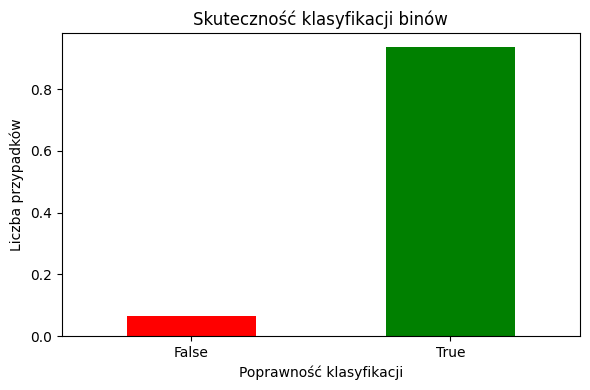

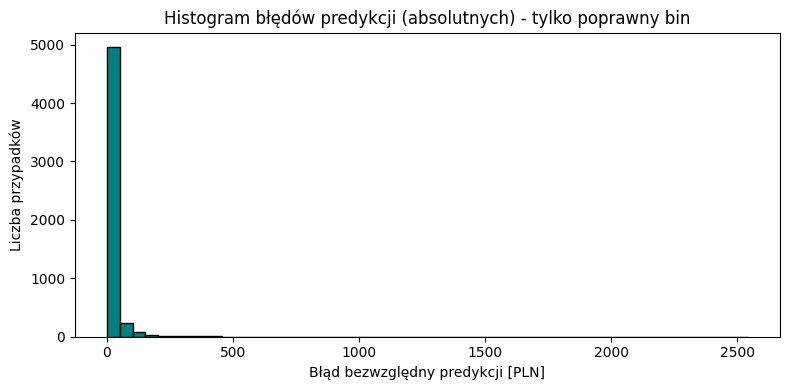

<Figure size 800x400 with 0 Axes>

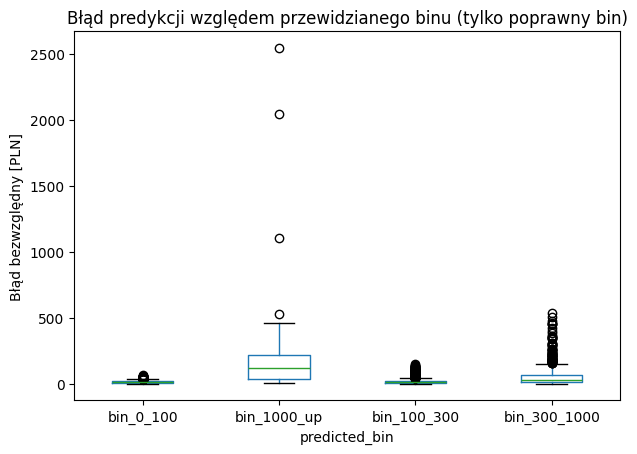

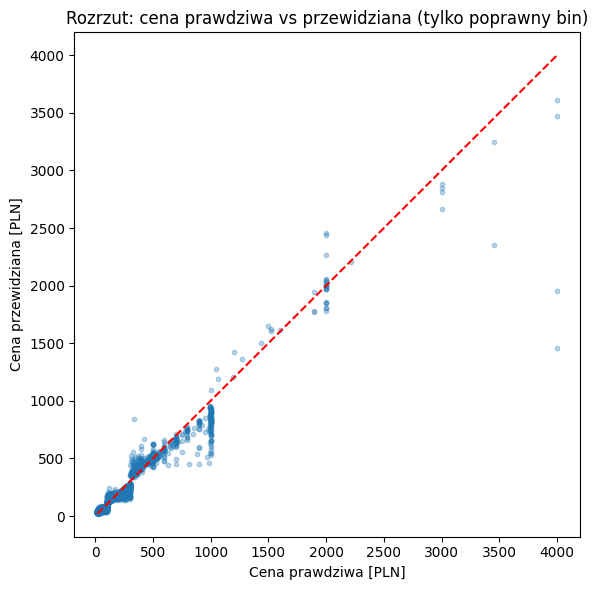

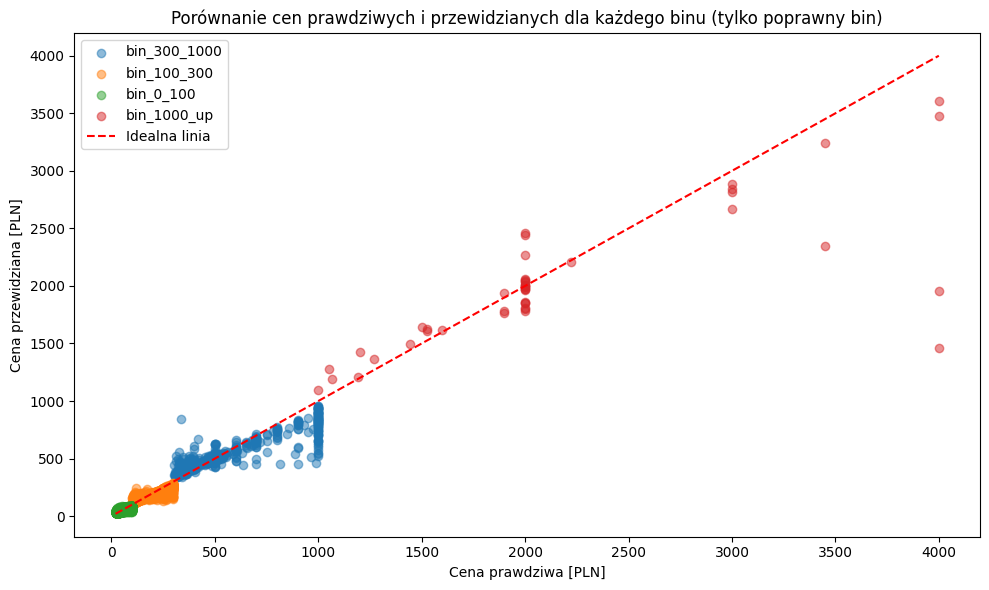

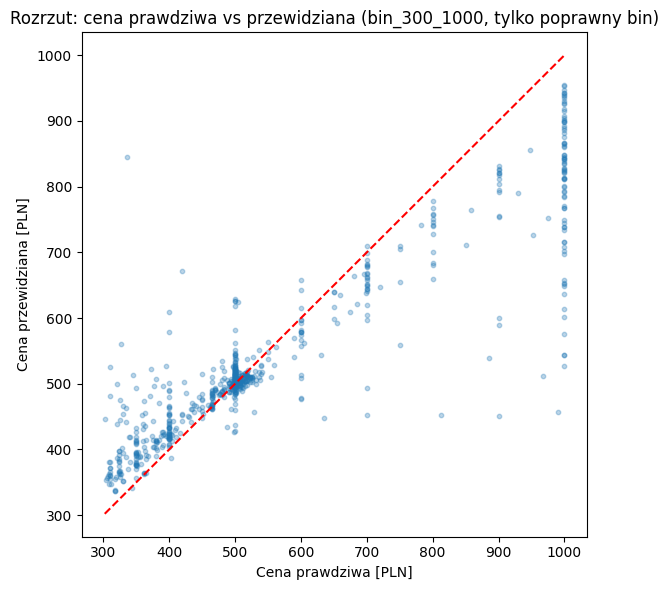

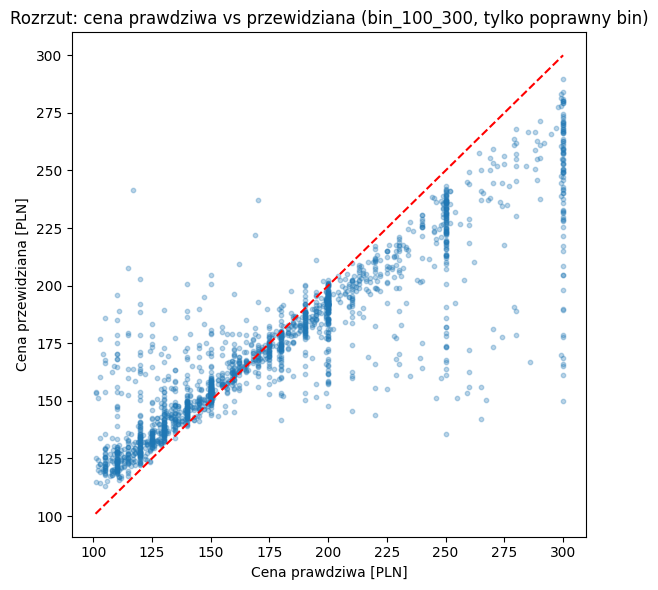

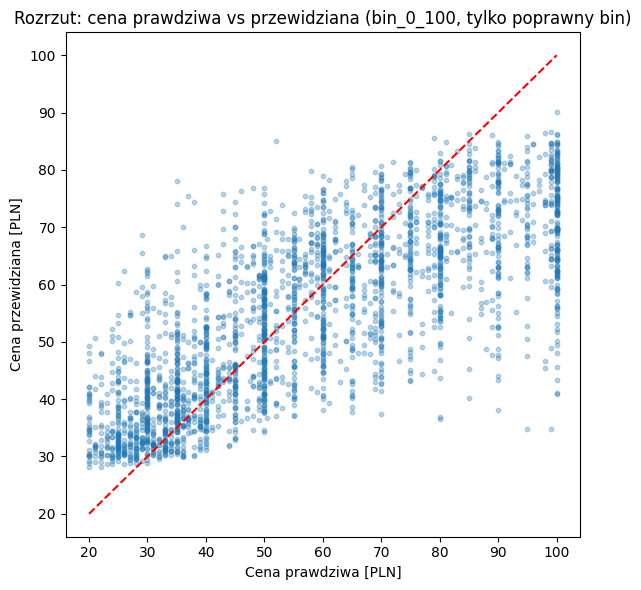

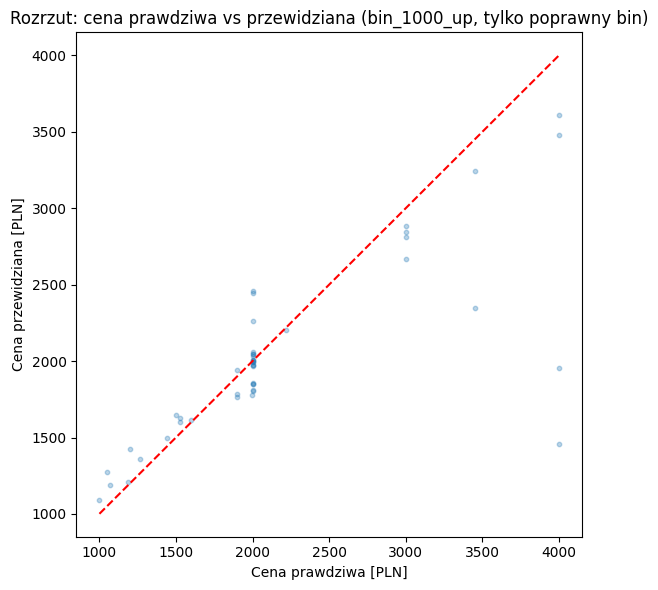

In [45]:
import pandas as pd

# Wczytaj plik z wynikami pełnej ewaluacji
import matplotlib.pyplot as plt

results = pd.read_csv("evaluation_full_pipeline.csv")

# Skuteczność klasyfikacji binów
bin_acc = results.groupby("predicted_bin")["correct"].mean()
print("Skuteczność klasyfikacji binów (predicted_bin):")
print(bin_acc)

# Skuteczność klasyfikacji względem prawdziwego binu
true_bin_acc = results.groupby("correct")["price"].count() / len(results)
print("\nUdział poprawnych/niepoprawnych klasyfikacji:")
print(true_bin_acc)
plt.figure(figsize=(6, 4))
true_bin_acc.plot(kind="bar", color=["red", "green"])
plt.xlabel("Poprawność klasyfikacji")
plt.ylabel("Liczba przypadków")
plt.title("Skuteczność klasyfikacji binów")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Filtruj tylko przypadki z poprawnie przewidzianym binem
correct_results = results[results["correct"]]

# Histogram błędów predykcji (absolute error) dla poprawnych binów
plt.figure(figsize=(8, 4))
plt.hist(correct_results["error"], bins=50, color="teal", edgecolor="black")
plt.xlabel("Błąd bezwzględny predykcji [PLN]")
plt.ylabel("Liczba przypadków")
plt.title("Histogram błędów predykcji (absolutnych) - tylko poprawny bin")
plt.tight_layout()
plt.show()

# Boxplot błędów predykcji dla każdego binu (tylko poprawny bin)
plt.figure(figsize=(8, 4))
correct_results.boxplot(column="error", by="predicted_bin", grid=False)
plt.ylabel("Błąd bezwzględny [PLN]")
plt.title("Błąd predykcji względem przewidzianego binu (tylko poprawny bin)")
plt.suptitle("")
plt.tight_layout()
plt.show()

# Wykres rozrzutu: cena prawdziwa vs przewidziana (tylko poprawny bin)
plt.figure(figsize=(6, 6))
plt.scatter(correct_results["price"], correct_results["predicted_price"], alpha=0.3, s=10)
plt.plot([correct_results["price"].min(), correct_results["price"].max()],
         [correct_results["price"].min(), correct_results["price"].max()], 'r--')
plt.xlabel("Cena prawdziwa [PLN]")
plt.ylabel("Cena przewidziana [PLN]")
plt.title("Rozrzut: cena prawdziwa vs przewidziana (tylko poprawny bin)")
plt.tight_layout()
plt.show()

# Wykresy skuteczności regresorów (tylko poprawny bin)
plt.figure(figsize=(10, 6))
for bin_label in correct_results["predicted_bin"].unique():
    subset = correct_results[correct_results["predicted_bin"] == bin_label]
    plt.scatter(subset["price"], subset["predicted_price"], label=bin_label, alpha=0.5)
plt.plot([correct_results["price"].min(), correct_results["price"].max()],
         [correct_results["price"].min(), correct_results["price"].max()], 'r--', label="Idealna linia")
plt.xlabel("Cena prawdziwa [PLN]")
plt.ylabel("Cena przewidziana [PLN]")
plt.title("Porównanie cen prawdziwych i przewidzianych dla każdego binu (tylko poprawny bin)")
plt.legend()
plt.tight_layout()
plt.show()

# Osobne wykresy dla każdego binu (tylko poprawny bin)
for bin_label in correct_results["predicted_bin"].unique():
    subset = correct_results[correct_results["predicted_bin"] == bin_label]
    plt.figure(figsize=(6, 6))
    plt.scatter(subset["price"], subset["predicted_price"], alpha=0.3, s=10)
    plt.plot([subset["price"].min(), subset["price"].max()],
             [subset["price"].min(), subset["price"].max()], 'r--')
    plt.xlabel("Cena prawdziwa [PLN]")
    plt.ylabel("Cena przewidziana [PLN]")
    plt.title(f"Rozrzut: cena prawdziwa vs przewidziana ({bin_label}, tylko poprawny bin)")
    plt.tight_layout()
    plt.show()
